In [1]:
import sys
import os

project_root = os.path.abspath("..")

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from src.simulation import *
from src.wave import *
import pandas as pd
import matplotlib.pyplot as plt # AI matplotlib assistance

In [3]:
def summarize(res):
    """Heler function to print out the results in a readable format."""
    print(f"Wave Count:           {res['wave_counts']}")
    print(f"Number of surfers:    {res['n_surfers']}")
    print(f"Avg Success Count:    {res['avg_success_count']:.2f}")
    print(f"Avg Collision Count:  {res['avg_collision_count']:.2f}")
    print(f"Avg Waitin time:      {res['avg_waiting_time']:.2f}")
    print(f"Inequality:             {res['fairness']:.3f}")

In [4]:
def summary_table(mean, std, label_name="condition"):
    """
    Construct a DataFrame from mean and standard deviation dictionares.
    """

    rows = []

    conditions = []
    for key in mean.keys():
        cond = key.replace("_mean", "")
        conditions.append(cond)      

    first_cond = conditions[0]
    metrics = mean[f"{first_cond}_mean"].keys()

    for cond in conditions:
        mean_vals = mean[f"{cond}_mean"]
        std_vals = std[f"{cond}_std"]
    
        for metric in metrics:
            rows.append({
                label_name: cond,
                "metric": metric,
                "mean": mean_vals[metric],
                "std": std_vals[metric]
            })

    return pd.DataFrame(rows)

# Validation 📑

### Sanity Check

Before further experiments, we performed simulations under several edge cases and extreme settings to examine the validity and robustness of the model.

**1. Zero-wave session（0 wave)**<br> This test covers an edge case where the wave schedule is empty, i.e., no waves are generated. Even though surfers are present in the simulation, no riding can occur. As a result, all statistics except for average waiting time should evaluate to zero. With no opportunities to ride, all surfers simply wait until the session ends. Additionally, the absence of competition results in zero fairness.

In [9]:
res = run_simulation(wave_schedule=[])
summarize(res)

Wave Count:           0
Number of surfers:    75
Avg Success Count:    0.00
Avg Collision Count:  0.00
Avg Waitin time:      3600.00
Inequality:             0.000


**2. Single-surfer session（1 surfer)**<br>This test checks the case where only one surfer is present in the simulation. With no competitors, collisions should never occur, and fairness is naturally zero. The surfer can still ride waves normally, so the success-related statistics should remain valid.

In [11]:
res = run_simulation(mode="experiment", num_surfer=1, ratio=0)
summarize(res)

Wave Count:           2057
Number of surfers:    1
Avg Success Count:    30.00
Avg Collision Count:  0.00
Avg Waitin time:      117.20
Inequality:             0.000


**3. Zero surfers（empty beach）**<br>This test the case where no surfer exists in the simulation. Even though there are waves during the simulation, no surfer will ride those waves. Accordingly, the statistics related to surfing activity should be zeros.

In [13]:
res = run_simulation(mode="experiment", num_surfer=0, ratio=0)
summarize(res)

Wave Count:           2140
Number of surfers:    0
Avg Success Count:    0.00
Avg Collision Count:  0.00
Avg Waitin time:      0.00
Inequality:             0.000


**4. Infinite waves (long duration)**<br>This is a stress test to check if the program still works noramlly in some extreme conditions, such as long duration.

In [62]:
results_val4 = []

for dur in [1000, 5000, 10000, 50000, 100000]:
    res = run_simulation(duration=dur, num_surfer=80)
    res["session_duration"] = dur
    res["avg_wave_counts"] = res["wave_counts"] / dur
    res["success_frequency"] = res["avg_success_count"] / dur
    res["collision_frequency"] = res["avg_collision_count"] / dur
    
    del res["avg_success_count"]
    del res["avg_collision_count"]
    del res["wave_counts"]
    results_val4.append(res)

In [63]:
df_val4 = pd.DataFrame(results_val4).set_index("session_duration")
df_val4

,spot_level,n_surfers,beginner_ratio,avg_waiting_time,fairness,avg_wave_counts,success_frequency,collision_frequency
session_duration,,,,,,,,
1000,beginner,80,None,959.689266,0.536935,0.57400,0.002213,0.011275
5000,beginner,80,None,374.764706,0.487594,0.61020,0.001998,0.011655
10000,beginner,80,None,294.850475,0.430110,0.57850,0.002893,0.011307
50000,beginner,80,None,356.410127,0.481553,0.57178,0.002533,0.011243
100000,beginner,80,None,378.658121,0.485349,0.57357,0.002584,0.011458


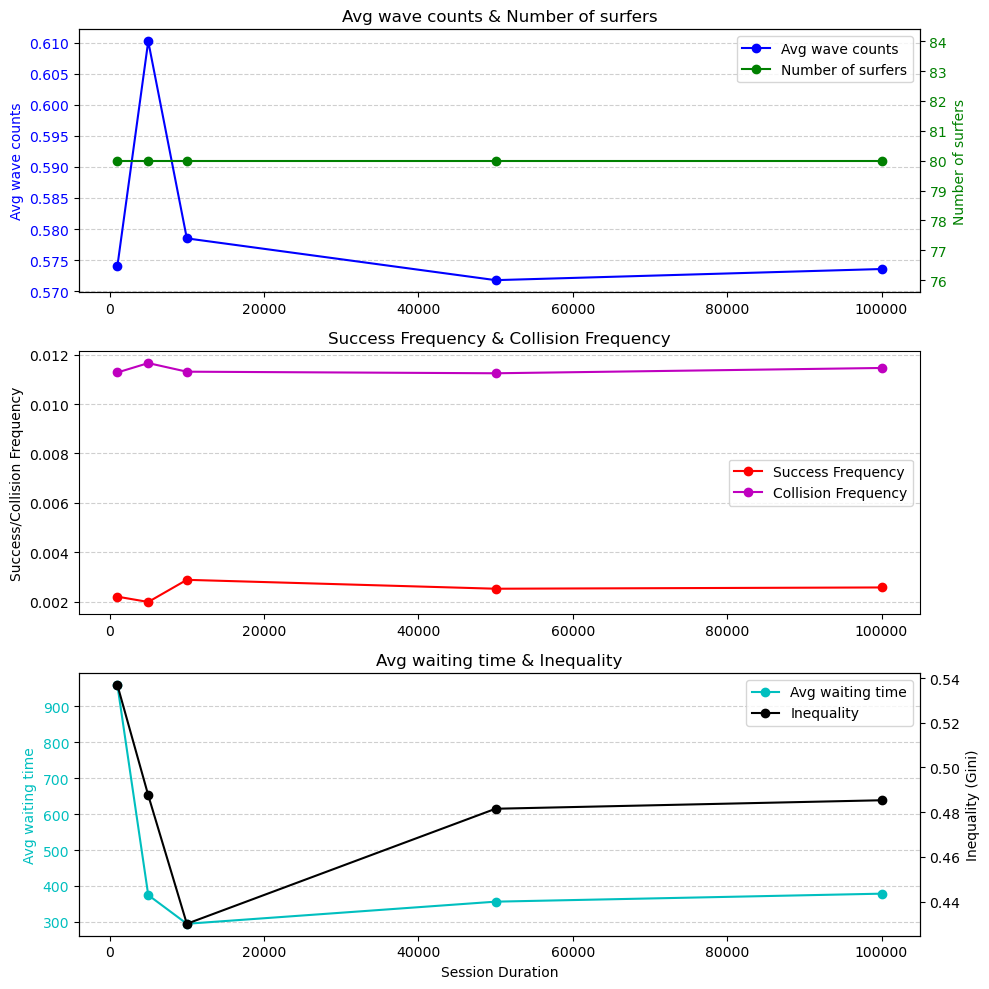

In [64]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

plt.xlabel("Session Duration")

# -- Subplot 1: Wave counts & Number of surfers --
ax1 = axes[0]
ax1.set_title("Avg wave counts & Number of surfers")   

(ln1,) = ax1.plot(df_val4.index, df_val4['avg_wave_counts'], 'b-o', label="Avg wave counts")
ax1.set_ylabel("Avg wave counts", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

ax1r = ax1.twinx()
(ln2,) = ax1r.plot(df_val4.index, df_val4['n_surfers'], 'g-o', label="Number of surfers")
ax1r.set_ylabel("Number of surfers", color='g')
ax1r.tick_params(axis='y', labelcolor='g')

ax1.legend([ln1, ln2], [ln1.get_label(), ln2.get_label()], loc="best")

# -- Subplot 2: Success Frequency & Collision Frequency --
ax2 = axes[1]
ax2.set_title("Success Frequency & Collision Frequency")

(ln3, ) = ax2.plot(df_val4.index, df_val4['success_frequency'], "r-o", label="Success Frequency")
ax2.set_ylabel("Success/Collision Frequency", color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)

(ln4,) = ax2.plot(df_val4.index, df_val4['collision_frequency'], 'm-o', label="Collision Frequency")

ax2.legend([ln3, ln4], [ln3.get_label(), ln4.get_label()], loc="best")

# -- Subplot 3: Avg waiting time & Fairness --
ax3 = axes[2]
ax3.set_title("Avg waiting time & Inequality")

(ln5, ) = ax3.plot(df_val4.index, df_val4['avg_waiting_time'], "c-o", label="Avg waiting time")
ax3.set_ylabel("Avg waiting time", color='c')
ax3.tick_params(axis='y', labelcolor='c')
ax3.grid(True, axis='y', linestyle='--', alpha=0.6)

ax3r = ax3.twinx()
(ln6,) = ax3r.plot(df_val4.index, df_val4['fairness'], 'k-o', label="Inequality")
ax3r.set_ylabel("Inequality (Gini)", color='k')
ax3r.tick_params(axis='y', labelcolor='k')

ax3.legend([ln5, ln6], [ln5.get_label(), ln6.get_label()], loc="best")


plt.tight_layout()

plt.show()

This stress test runs the simulation from 1,000 up to 100,100 time steps and shows two main results. The model stays stable under a very long running time, with no runtime errors or crashes. In addition, as the simulation runs longer, the key metrics gradually stabilize, showing that the model moves past the initial transient phase and eventually reaches a steady state. 

### Convergence Analysis
We performed a convergence analysis to check the stability of the model before conducting the main experiments. The simulation was run independently 100 times, and each run lasted 3600 time units. We then tracked the cumulative average (running mean) of several key metrics. This allows us to identify the number of runs needed before the results converge.

In [20]:
data, mean, std = run_many(num_surfer=80)

 Running 100 Monte Carlo iterations...


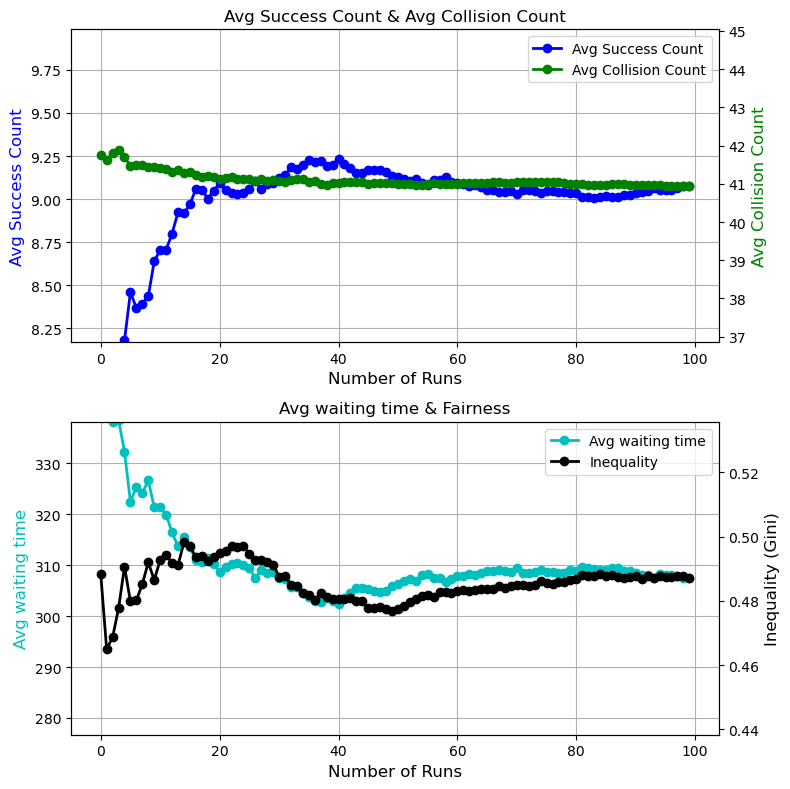

In [21]:
df = pd.DataFrame(data)

# calculate cumulative average
for metric in ['avg_success_count', 'avg_collision_count', 'avg_waiting_time', 'fairness']:
    df[metric] = df[metric].expanding().mean()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# set Y-axis range
def set_smart_ylim(ax, data_series, margin=0.1):
    final_val = data_series.iloc[-1]
    ax.set_ylim(final_val * (1 - margin), final_val * (1 + margin))

# -- Subplot 1: Avg Success Count & Avg Collision Count --
ax1 = axes[0]
ax1.set_title("Avg Success Count & Avg Collision Count")   
ax1.set_xlabel('Number of Runs', fontsize=12)

(line1, ) = ax1.plot(df.index, df['avg_success_count'], 'b-o', linewidth=2, label='Avg Success Count')
ax1.set_ylabel('Avg Success Count', fontsize=12, color='b')
set_smart_ylim(ax1, df['avg_success_count'])

ax1r = ax1.twinx()
(line2, ) = ax1r.plot(df.index, df['avg_collision_count'], 'g-o', linewidth=2, label='Avg Collision Count')
ax1r.set_ylabel("Avg Collision Count", fontsize=12, color='g')
set_smart_ylim(ax1r, df['avg_collision_count'])

plt.legend([line1, line2], [line1.get_label(), line2.get_label()], loc="best")
ax1.grid(True)

# -- Subplot 2: Avg waiting time & Fairness --
ax2 = axes[1]
ax2.set_title("Avg waiting time & Fairness")   
ax2.set_xlabel('Number of Runs', fontsize=12)

(line3, ) = ax2.plot(df.index, df['avg_waiting_time'], 'c-o', linewidth=2, label='Avg waiting time')
ax2.set_ylabel('Avg waiting time', fontsize=12, color='c')
set_smart_ylim(ax2, df['avg_waiting_time'])

ax2r = ax2.twinx()
(line4, ) = ax2r.plot(df.index, df['fairness'], 'k-o', linewidth=2, label='Inequality')
ax2r.set_ylabel("Inequality (Gini)", fontsize=12, color='k')
set_smart_ylim(ax2r, df['fairness'])

plt.legend([line3, line4], [line3.get_label(), line4.get_label()], loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()

The convergence analysis shows that most key metrics become stable after around 80 runs. Based on this observation, we set the number of simulation runs to N=100 to balance statistical reliability and computational cost.

## Experiments 🔬

#### Hypothesis 1: When the rule is free-for-all, advanced spots usually run smoother because skilled surfers handle the lineup better. This lowers waiting time and also lowers the Gini score since waves are shared more evenly. Beginner spots are much more chaotic, so waiting time goes up and the Gini score increases as skilled surfers still catch more waves while beginners struggle.

In [25]:
# Fix Poisson λ for wave counts
import copy

beg_conf = copy.deepcopy(SPOT_CONF["beginner"])
mix_conf = copy.deepcopy(SPOT_CONF["mixed"])
adv_conf = copy.deepcopy(SPOT_CONF["advanced"])

fixed_lambda = 4.5

beg_conf["lambda_set"] = fixed_lambda
mix_conf["lambda_set"] = fixed_lambda
adv_conf["lambda_set"] = fixed_lambda

# Run for three different spot levels
_, mean_beg, std_beg = run_many(num_surfer=80, spot_conf = beg_conf, spot_level="beginner")
_, mean_mix, std_mix = run_many(num_surfer=80, spot_conf = mix_conf, spot_level="mixed")
_, mean_adv, std_adv = run_many(num_surfer=80, spot_conf = adv_conf, spot_level="advanced")

mean = {
    "beg_mean": mean_beg,
    "mix_mean": mean_mix,
    "adv_mean": mean_adv
}

std = {
    "beg_std": std_beg,
    "mix_std": std_mix,
    "adv_std": std_adv
}

df_level = summary_table(mean, std, label_name="spot_level")
df_level["rule_type"] = "free-for-all"
df_level = df_level.set_index(["rule_type", "spot_level", "metric"])
print(df_level.round(3))

 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
                                                 mean     std
rule_type    spot_level metric                               
free-for-all beg        n_surfers              80.000   0.000
                        wave_counts          2705.490  94.429
                        avg_success_count      10.069   0.977
                        avg_collision_count    42.640   0.833
                        avg_waiting_time      277.639  26.524
                        fairness                0.468   0.040
             mix        n_surfers              80.000   0.000
                        wave_counts          2697.510  95.605
                        avg_success_count      16.056   0.864
                        avg_collision_count    35.454   0.579
                        avg_waiting_time      192.288   8.212
                        fairness                0.261   0.029
             ad

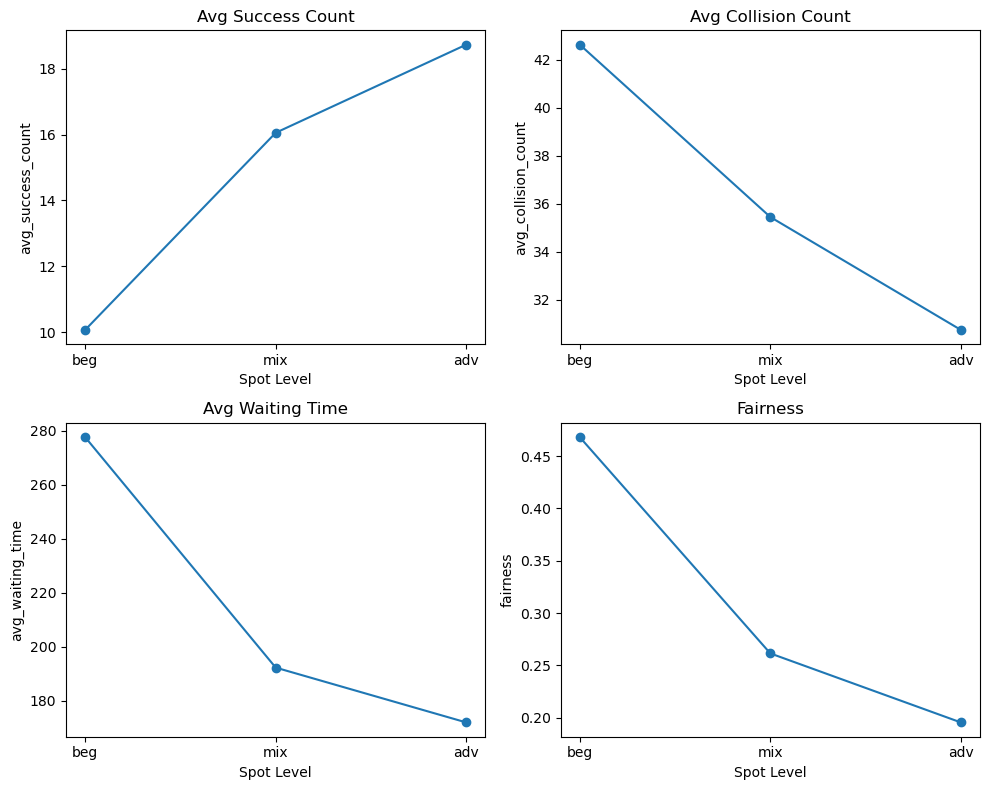

In [26]:
metrics = ["avg_success_count", "avg_collision_count", "avg_waiting_time", "fairness"]
spot_levels = ["beg", "mix", "adv"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    values = []
    for spot in spot_levels:
        values.append(df_level.loc[("free-for-all", spot, metric), "mean"])

    ax.plot(spot_levels, values, marker='o')
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Spot Level")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

**Analysis**

Looking at the comparison across spot levels, our simulation results support the hypothesis:

1. The **Average Success Count** almost doubles when moving from Beginner to Advanced, while **Collisions** drop by about 25%. This shows that higher skill levels really help the lineup run smoother and safer.
2. We see a clear drop in **Waiting Time**. This is mainly because beginners have a lower success rate—they spend a lot of time missing waves or falling before they finally get a good one. Advanced surfers are much more consistent, so the time between their successful rides is way shorter.
3. The **Gini Index** drops significantly (lower is better). This tells us that in advanced spots, the "free-for-all" rule doesn't let just a few people hog all the waves. Instead, skilled surfers actually share waves more evenly compared to the chaotic distribution in beginner spots.

#### Hypothesis 2: We expect the 'Safe-Distance' rule (yielding within 10m) to reduce collisions. However, this comes with a trade-off: we anticipate fewer successful rides and longer waiting times, as surfers are forced to abort rides more often to stay safe.

In [29]:
dataframes = []

for level in ["beginner", "mixed", "advanced"]:
    # run for both rule types
    _, mean_free, std_free = run_many(rule_type="free_for_all", num_surfer=80, spot_level=level)
    _, mean_first, std_first = run_many(rule_type="safe_distance", num_surfer=80, spot_level=level)
    
    mean = {
        "free_mean": mean_free,
        "safe_mean": mean_first
    }
    
    std = {
        "free_std": std_free,
        "safe_std": std_first
    }

    df = summary_table(mean, std, label_name="rule_type")
    df["spot_level"] = level
    dataframes.append(df)

 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...


In [30]:
# total summary table
h2_all_tables = pd.concat(dataframes)
h2_all_tables = h2_all_tables.set_index(["spot_level", "rule_type", "metric"])
print(h2_all_tables.round(3))

                                              mean      std
spot_level rule_type metric                                
beginner   free      n_surfers              80.000    0.000
                     wave_counts          2108.950   82.287
                     avg_success_count       9.170    0.815
                     avg_collision_count    40.888    0.827
                     avg_waiting_time      303.361   27.818
                     fairness                0.488    0.046
           safe      n_surfers              80.000    0.000
                     wave_counts          2102.370   73.518
                     avg_success_count       8.232    0.841
                     avg_collision_count    38.762    0.948
                     avg_waiting_time      341.476   38.419
                     fairness                0.524    0.048
mixed      free      n_surfers              80.000    0.000
                     wave_counts          2701.170   86.595
                     avg_success_count  

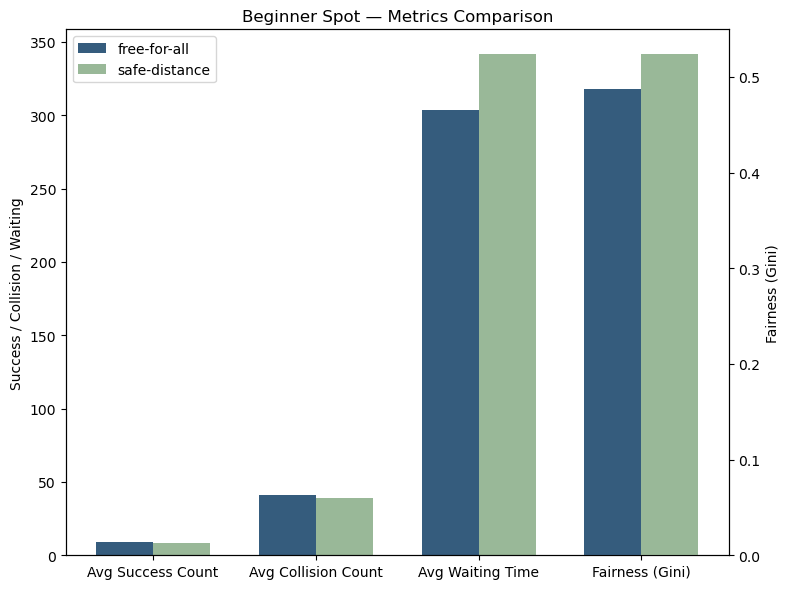

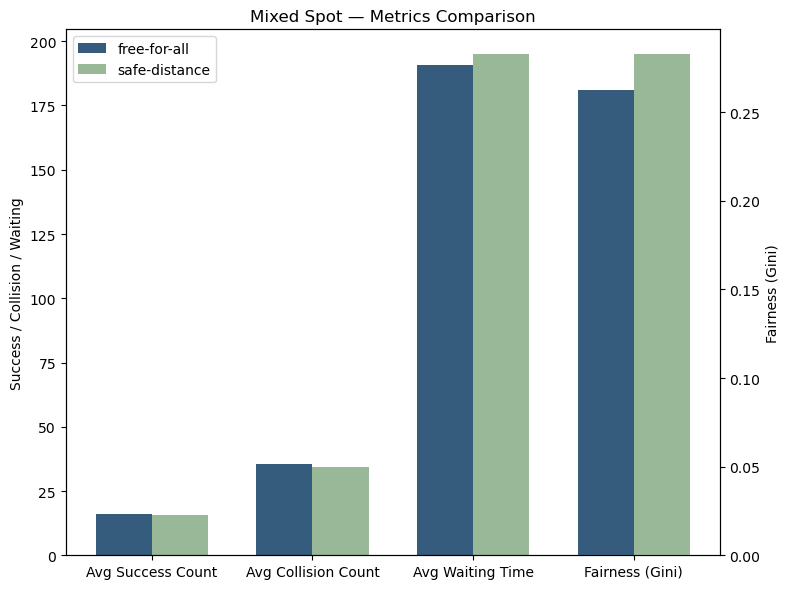

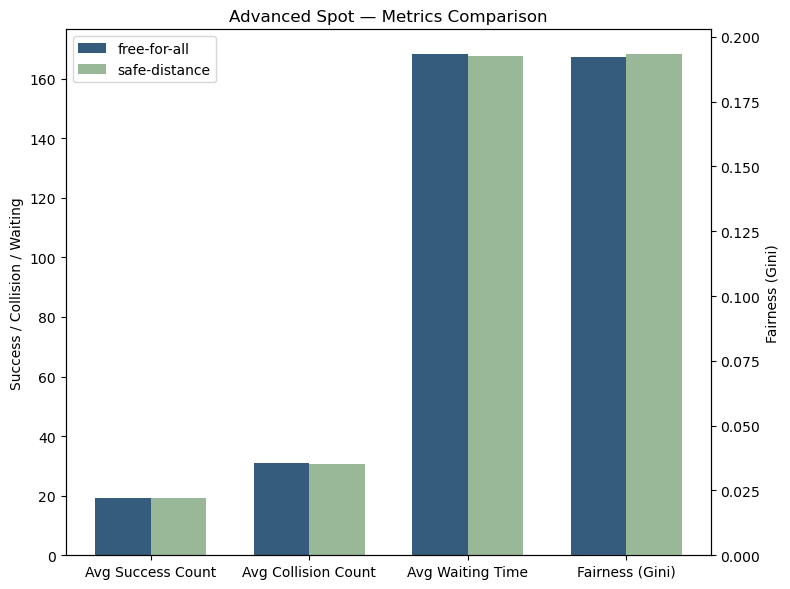

In [31]:
import numpy as np

metrics = ["avg_success_count", "avg_collision_count", "avg_waiting_time", "fairness"]
metric_titles = ["Avg Success Count", "Avg Collision Count", "Avg Waiting Time", "Fairness (Gini)"]
spot_levels = ["beginner", "mixed", "advanced"]

rule_labels = {"free": "free-for-all", "safe": "safe-distance"}
colors = ["#355C7D", "#99B898"]


for level in spot_levels:
    fig, ax_left = plt.subplots(figsize=(8, 6))
    
    # secondary axis for fairness
    ax_right = ax_left.twinx()  

    x = np.arange(len(metrics))
    bar_width = 0.35

    # extract values
    free_vals = [h2_all_tables.loc[(level, "free", m), "mean"] for m in metrics]
    first_vals = [h2_all_tables.loc[(level, "safe", m), "mean"] for m in metrics]

    # split metrics: fairness goes to right axis
    fairness_idx = metrics.index("fairness")

    # left-axis metrics masks
    left_idx = [i for i in range(len(metrics)) if i != fairness_idx]

    # --- draw left-axis bars ---
    ax_left.bar(x[left_idx] - bar_width/2,
                [free_vals[i] for i in left_idx],
                bar_width, label=rule_labels["free"],
                color=colors[0])

    ax_left.bar(x[left_idx] + bar_width/2,
                [first_vals[i] for i in left_idx],
                bar_width, label=rule_labels["safe"],
                color=colors[1])

    # --- draw right-axis bars for fairness only ---
    ax_right.bar(x[fairness_idx] - bar_width/2,
                 free_vals[fairness_idx],
                 bar_width, color=colors[0])

    ax_right.bar(x[fairness_idx] + bar_width/2,
                 first_vals[fairness_idx],
                 bar_width, color=colors[1])

    # labels / formatting
    ax_left.set_xticks(x)
    ax_left.set_xticklabels(metric_titles)
    ax_left.set_title(f"{level.capitalize()} Spot — Metrics Comparison")

    ax_left.set_ylabel("Success / Collision / Waiting")
    ax_right.set_ylabel("Fairness (Gini)")

    # legend only from left axis
    ax_left.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

**Analysis**

Contrary to our hypothesis, the simulation results revealed some surprising patterns:


1. Across all spot levels, the metrics for success rates and collisions are almost identical. This suggests that in our model, skill level play a much bigger role than specific rules in determining safety and efficiency.

2. We found that the "Safe-Distance" rule actually made the beginner spot **less fair** (higher Gini score) compared to Free-for-All. This is likely because the safety rule acts as a barrier. In a beginner spot, restricting surfers from going when someone is close might hurt those who are already struggling to catch waves, while aggressive surfers might not be as affected. The "Free-for-All" chaos, ironically, gives everyone a random chance to try.

3. As the spot level increases to Mixed and Advanced, the gap between the two rules narrows until it practically disappears. Advanced surfers naturally have high skill parameters, meaning they wait further out and pick different waves instead of fighting for the same one. They don't need a "Safe-Distance" rule to avoid crashes or improve fairness—they do it naturally. Therefore, enforcing the rule becomes redundant and doesn't change the outcome metrics.

#### Hypothesis 3: Higher wave heights will reduce the number of collisions, even when there is a high percentage of beginners.

Having more beginners usually leads to more collisions due to poor control. However, we hypothesize that when waves are significantly bigger, the difficulty acts as a natural filter. Since beginners will likely wipe out or fail to catch the wave early on, fewer unskilled surfers actually make it onto the wave, leading to fewer collisions than expected.

In [35]:
def run_h3_experiment(spot_level, ratios, base, wave50):
    dfs = []
    for ratio in ratios:
        _, mean_base, std_base = run_many(mode="experiment", ratio=ratio, spot_conf=base, spot_level=spot_level)
        _, mean_wave50, std_wave50 = run_many(mode="experiment", ratio=ratio, spot_conf=wave50, spot_level=spot_level)
        
        mean = {
            "base_mean": mean_base,
            "wave50_mean": mean_wave50
        }
        
        std = {
            "base_std": std_base,
            "wave50_std": std_wave50
        }
    
        df = summary_table(mean, std, label_name="wave_height")
        df["beg_ratio"] = int(ratio * 100)
        df["spot_level"] = spot_level
        dfs.append(df)
    return pd.concat(dfs)

In [36]:
import copy

# baseline config
base_beg = SPOT_CONF["beginner"]
base_mix = SPOT_CONF["mixed"]
base_adv = SPOT_CONF["advanced"]

# wave-enhanced config
wave50_beg = copy.deepcopy(base_beg)
wave50_beg["wave_height"]["mu"] *= 1.5
wave50_beg["wave_height"]["max"] += 2.0

wave50_mix = copy.deepcopy(base_mix)
wave50_mix["wave_height"]["mu"] *= 1.5
wave50_mix["wave_height"]["max"] += 2.0

wave50_adv = copy.deepcopy(base_adv)
wave50_adv["wave_height"]["mu"] *= 1.5
wave50_adv["wave_height"]["max"] += 2.0

ratios = [0, 0.2, 0.4, 0.6, 0.8]

h3_beginner = run_h3_experiment("beginner", ratios, base_beg, wave50_beg)
h3_mixed = run_h3_experiment("mixed", ratios, base_mix, wave50_mix)
h3_advanced = run_h3_experiment("advanced", ratios, base_adv, wave50_adv)

 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo iterations...
 Running 100 Monte Carlo 

In [37]:
# total summary table
h3_all_tables = pd.concat([h3_beginner, h3_mixed, h3_advanced])
h3_all_tables = h3_all_tables.set_index(["spot_level", "beg_ratio", "metric"])
print(h3_all_tables)

                                         wave_height         mean         std
spot_level beg_ratio metric                                                  
beginner   0         n_surfers                  base    80.000000    0.000000
                     wave_counts                base  2103.160000   80.930288
                     avg_success_count          base    14.345875    0.666056
                     avg_collision_count        base    29.999250    0.434384
                     avg_waiting_time           base   207.620179    7.849894
...                                              ...          ...         ...
advanced   80        wave_counts              wave50  3317.580000  110.009933
                     avg_success_count        wave50     8.752750    0.623753
                     avg_collision_count      wave50    19.399875    1.111964
                     avg_waiting_time         wave50   342.918978   27.083776
                     fairness                 wave50     0.64635

/var/folders/1q/8wfrycxj3mldfpmmqf_1kvbr0000gn/T/ipykernel_95155/546959235.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_row = h3_all_tables.loc[(spot, r, metric)]


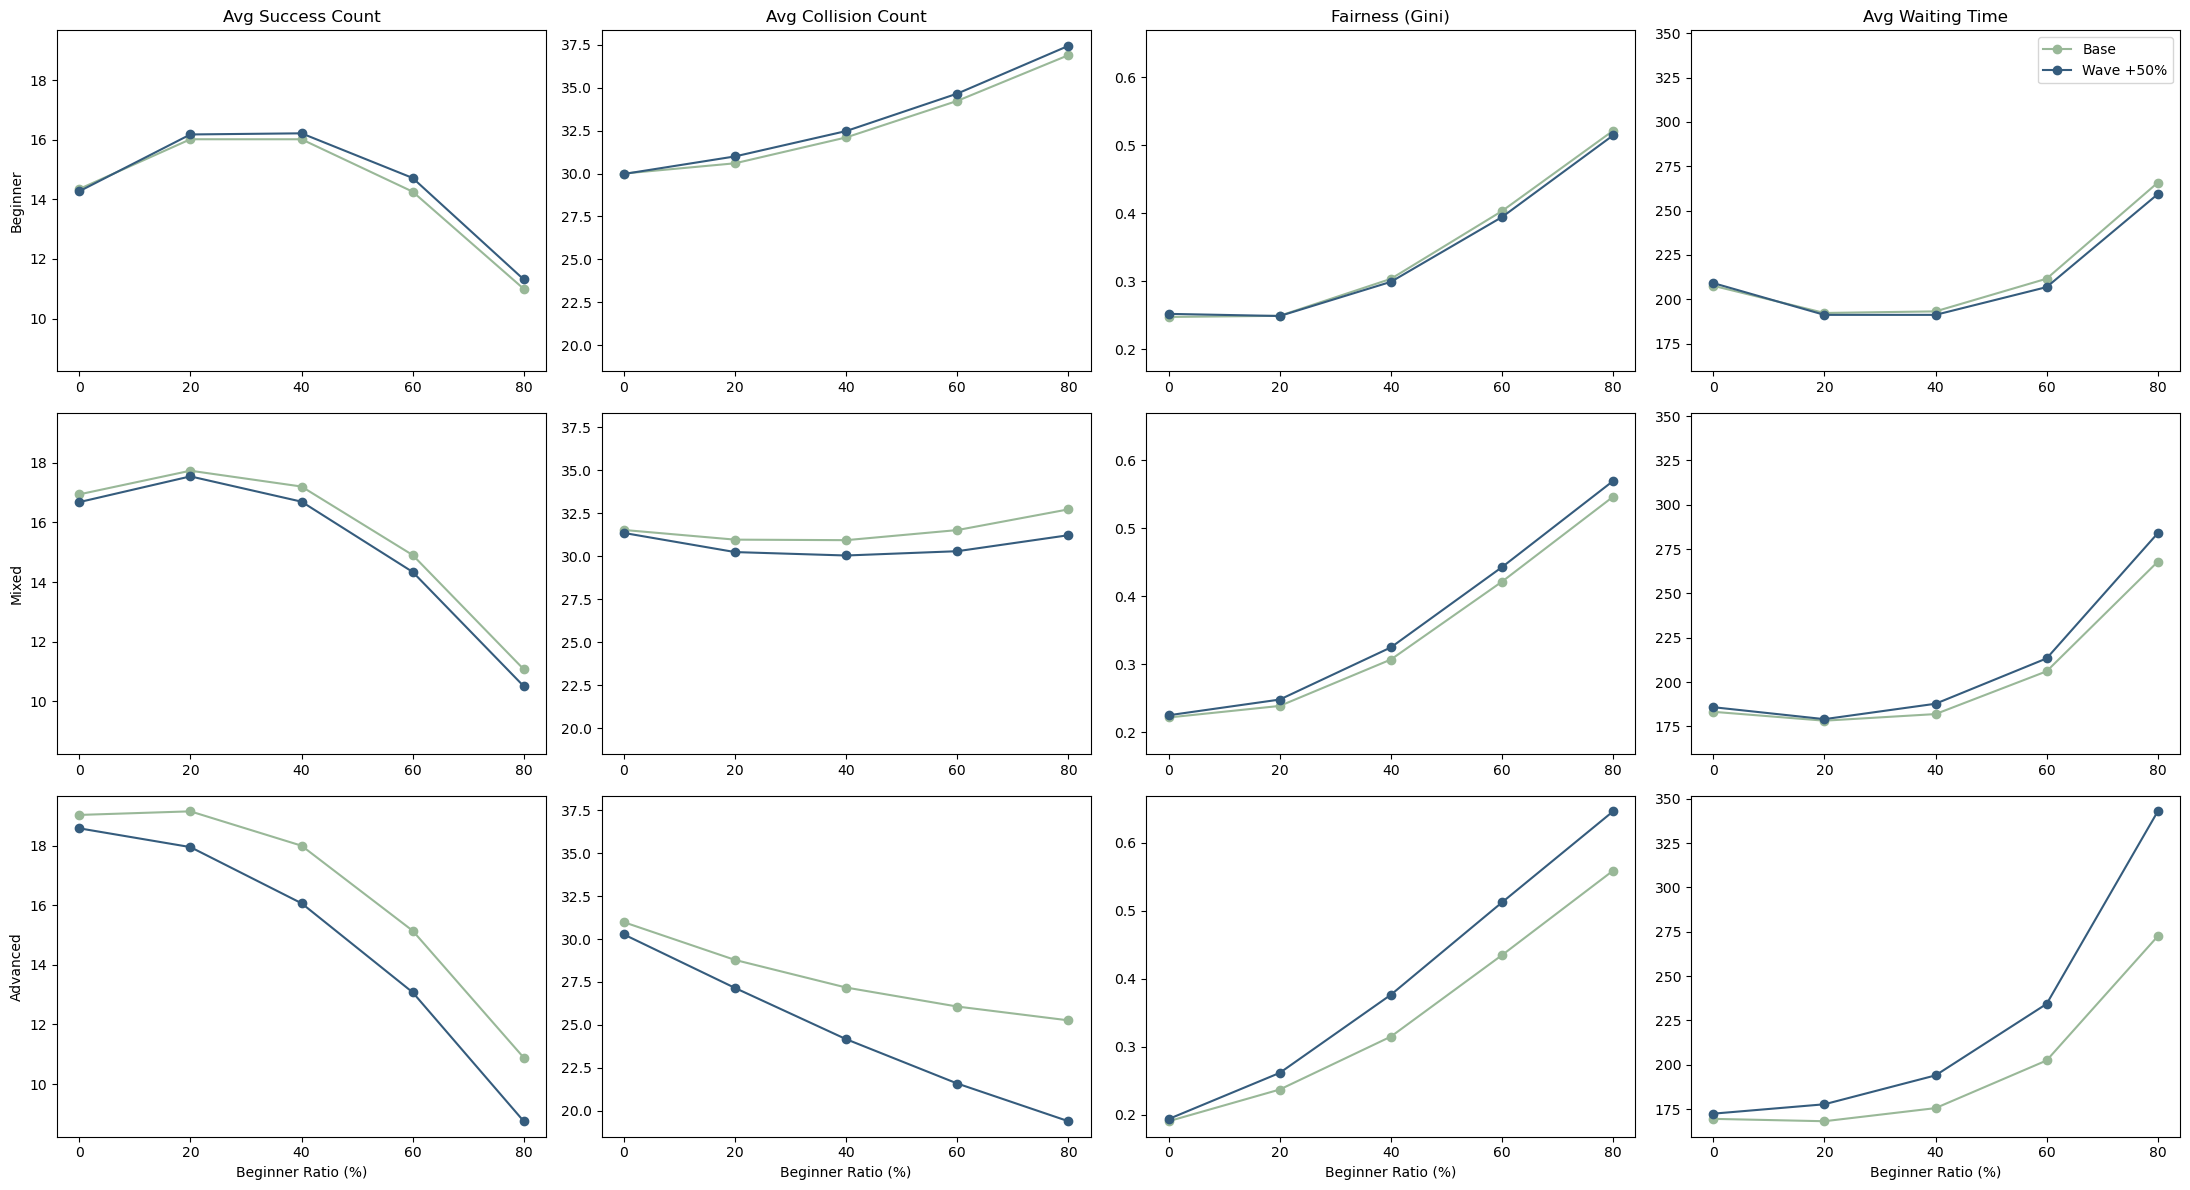

In [38]:
spot_levels = ["beginner", "mixed", "advanced"]
metrics = ["avg_success_count", "avg_collision_count", "fairness", "avg_waiting_time"]
titles = ["Avg Success Count", "Avg Collision Count", "Fairness (Gini)", "Avg Waiting Time"]
ratios = [0, 20, 40, 60, 80]

fig, axes = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(22, 12),
    sharey="col"
)

for row, spot in enumerate(spot_levels):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]

        base_vals = []
        wave50_vals = []

        for r in ratios:
            df_row = h3_all_tables.loc[(spot, r, metric)]

            base_vals.append(
                df_row.loc[df_row["wave_height"] == "base", "mean"].iloc[0]
            )
            wave50_vals.append(
                df_row.loc[df_row["wave_height"] == "wave50", "mean"].iloc[0]
            )

        ax.plot(ratios, base_vals, marker="o", color="#99B898", label="Base")
        ax.plot(ratios, wave50_vals, marker="o", color="#355C7D", label="Wave +50%")

        if row == 0:
            ax.set_title(titles[col])

        if col == 0:
            ax.set_ylabel(spot.capitalize())

        ax.set_xticks(ratios)

        if row == 2:
            ax.set_xlabel("Beginner Ratio (%)")

        if row == 0 and col == 3:
            ax.legend()

plt.tight_layout()
plt.show()


**Analysis**: <br> 
The simulation results partially support the hypothesis.
1. At the beginner spot, increasing the wave height by 50% didn't really change the results. However, in the mixed and advanced spots, we observed that this increase actually lowered the collision count.
2. As the spot difficulty increases, the gap between normal and high waves gets bigger. This shows that the 'filtering effect' is much stronger in harder environments—big waves effectively stop unskilled surfers from clogging the lineup.
3. The collision trend flips as the spot gets harder. In beginner spots, more beginners mean more crashes. But in advanced spots, more beginners actually lead to fewer crashes. This is because the waves are too difficult for them—fewer people successfully ride, so there are fewer chances to collide.
4. Other metrics like Waiting Time and Fairness (Gini) also behaved as expected: tougher conditions meant longer waits and less fairness. Just like the collision rate, these metrics became much more sensitive to wave height changes in the advanced spots compared to the beginner ones.